<a href="https://colab.research.google.com/github/vjacobsen/Liquor-Sales-Inventory-Forecast/blob/main/Liquor_Safety_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Safety Stock Calculation

The approach used considers forecast error as the only factor requiring buffer inventory. 

Also, forecast error is assumed to be normally distributed.

In a real world scenario, additional variables such as supplier lead time would also need to be added.

In [177]:
import os
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import datetime 

#### Query
This is the forecast table loaded to Google Cloud in the previous notebook

In [2]:
### Provide your credentials to the runtime
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()
print('Authenticated')

project_id = 'iowa-liquor-sales-266301'
bq_dataset_name = "forecasting"

# Construct a BigQuery client object
client = bigquery.Client(project = project_id,)

Authenticated


In [91]:
# Run query for forecast dataset
forecasts_query = client.query('''
SELECT *
FROM 
`iowa-liquor-sales-266301.forecasting.ml_forecasts`
''').to_dataframe()

In [247]:
forecasts_query

,forecast_key,week_date,forecast,mape,best_model,trim_date,type,week_end_date,date,is_holiday,day_of_week,sales_bottles,item_number,category_name,item_description,vendor_number
0,67586,2016-11-13,22.0,0.26,ElasticNet,2020-01-12,train,2016-11-13,2016-11-07,0,0,12.0,67586,Coffee Liqueurs,Kapali Coffee Liqueur,421
1,67586,2016-11-20,28.0,0.26,ElasticNet,2020-01-12,train,2016-11-20,2016-11-14,0,0,16.0,67586,Coffee Liqueurs,Kapali Coffee Liqueur,421
2,67586,2016-11-27,22.0,0.26,ElasticNet,2020-01-12,train,2016-11-27,2016-11-21,0,0,60.0,67586,Coffee Liqueurs,Kapali Coffee Liqueur,421
3,67586,2016-12-04,25.0,0.26,ElasticNet,2020-01-12,train,2016-12-04,2016-11-28,0,0,0.0,67586,Coffee Liqueurs,Kapali Coffee Liqueur,421
4,67586,2016-12-11,22.0,0.26,ElasticNet,2020-01-12,train,2016-12-11,2016-12-05,0,0,0.0,67586,Coffee Liqueurs,Kapali Coffee Liqueur,421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231931,69631,2021-09-26,0.0,0.25,XGBoost_Trended,2020-01-12,forecast,2021-09-26,2021-09-26,0,6,NaN,69631,Imported Schnapps,Dr McGillicuddys Cherry Mini,421
231932,69631,2021-10-03,0.0,0.25,XGBoost_Trended,2020-01-12,forecast,2021-10-03,2021-10-03,0,6,NaN,69631,Imported Schnapps,Dr McGillicuddys Cherry Mini,421
231933,69631,2021-10-10,0.0,0.25,XGBoost_Trended,2020-01-12,forecast,2021-10-10,2021-10-10,0,6,NaN,69631,Imported Schnapps,Dr McGillicuddys Cherry Mini,421
231934,69631,2021-10-17,0.0,0.25,XGBoost_Trended,2020-01-12,forecast,2021-10-17,2021-10-17,0,6,NaN,69631,Imported Schnapps,Dr McGillicuddys Cherry Mini,421


## Transform data

Data is grouped by month-year and forecast error is calulated at this level

In [314]:
forecasts = forecasts_query.copy()

# Convert string to date
forecasts['date'] = pd.to_datetime(forecasts_query['date'])

# Convert key number to str
forecasts['forecast_key'] = forecasts['forecast_key'].astype(str)

# Group by month-year
forecasts['month_year'] = forecasts['date'].dt.month.astype(str) +  "_" + forecasts['date'].dt.year.astype(str)
forecasts['year'] = forecasts['date'].dt.year.astype(str)

monthly_forecasts = forecasts.groupby(['forecast_key','month_year','type','year']).agg({"sales_bottles":sum,"forecast":sum,"date":max}).reset_index()
monthly_forecasts.rename(columns={'date':'month_end'},inplace=True)

# Historical only
historical = monthly_forecasts[monthly_forecasts['type']!='forecast'] 

# Future forecast only
forecasts_weekly = forecasts[forecasts['type']=='forecast'] 
monthly_forecasts = monthly_forecasts[monthly_forecasts['type']=='forecast'] 

target_value = 'sales_bottles'

historical['error'] = historical['forecast'] - historical[target_value]  # Error
historical.head()

,forecast_key,month_year,type,year,sales_bottles,forecast,month_end,error
0,100015,10_2017,train,2017,291.0,171.0,2017-10-31,-120.0
1,100015,10_2018,train,2018,188.0,174.0,2018-10-31,-14.0
2,100015,10_2019,train,2019,0.0,153.0,2019-10-31,153.0
4,100015,10_2020,test,2020,93.0,135.0,2020-10-25,42.0
6,100015,11_2017,train,2017,136.0,75.0,2017-11-30,-61.0


## Inventory Optimization
### Historical Error distribution
We'll look at percetage error to allow for better comparison

In [315]:
# Calculate MAPE
historical['mape_pcnt'] = (np.divide(historical['error'],historical['sales_bottles']).abs()).round(2)

# Infinite MAPE values are generated when error is 0, replace with 0
non_infinite_mask = ~historical['mape_pcnt'].isin([np.inf,-np.inf])

historical['mape_pcnt'] = historical['mape_pcnt'].where(non_infinite_mask,other=0)

# Summary
historical.describe().round(2)

,sales_bottles,forecast,error,mape_pcnt
count,5924.00,5924.00,5924.00,5499.00
mean,2327.72,2286.00,-41.72,0.41
std,11301.21,11212.37,969.62,3.43
min,0.00,-517.00,-17425.00,0.00
25%,69.00,80.00,-56.00,0.05
50%,338.00,340.00,0.00,0.14
75%,1234.00,1158.50,52.00,0.34
max,186832.00,187566.00,11955.00,175.17


Looking at the summary table, we notice some extreme error values

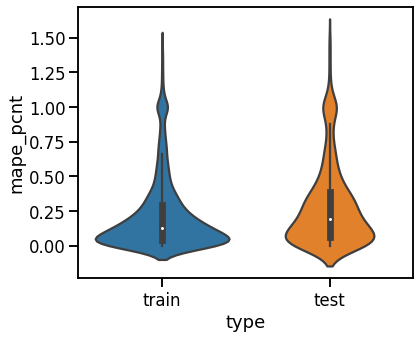


 118 item-months have error above 150%

 They represent 2.0% of total items-month keys


In [316]:
sns.set_context('talk')

# Violin plot without extreme values
data = historical[historical['mape_pcnt']<1.5]

# Plot
plt.figure(figsize=(6,5))
sns.violinplot(x=data['type'],y=data['mape_pcnt'])
plt.show()

# How many item - months have MAPE error above 150%?
print("\n {} item-months have error above 150%".format(len(historical[historical['mape_pcnt']>1.5])))

percent_of_total =  (len(historical[historical['mape_pcnt']>1.5])/len(historical))*100
print("\n They represent {}% of total items-month keys".format(round(percent_of_total,1)))

### Calculate Reorder Quantity

We'll use the Minimum Order Quantity formula:

$ EOQ = \sqrt{2 *\dfrac{Annual Demand * Cost per Order}{Annual Holding Cost  per Unit}} $


* Annual holding cost is set at 15% of the bottle's cost
* The bottle cost is 60% of the retail value  


It is known that the main limitation against the use of this formula is that demand needs to be constant throughout time, which is not the case for this project but the formula is still used for simplicity.

We must first get the average bottle price by querying the sales data in the last year

In [317]:
item_price = client.query('''

  SELECT 
    item_number,
    item_description,
    category_name, 
    SUM(sale_dollars)/SUM(bottles_sold) as avg_price

  FROM `bigquery-public-data.iowa_liquor_sales.sales`

  WHERE 
    date > DATE_SUB((SELECT MAX(date) FROM `bigquery-public-data.iowa_liquor_sales.sales`), INTERVAL 1 YEAR) AND 
    vendor_number = '421'

  GROUP BY
    item_number, 
    category_name, 
    item_description

''').to_dataframe()

# Create dictionary to aid in lookup
item_price_dict = item_price.set_index('item_number')['avg_price'].to_dict()
item_price.sample(3)

,item_number,item_description,category_name,avg_price
42,938081,Platinum 7x Vodka Mini,American Vodka,9.00
62,89301,Dorado Gold Tequila,Mixto Tequila,7.68
72,73140,Chila Orchata,Cream Liqueurs,13.01


We are looking to calculate the reorder quantity for the next year. To do that, first we query the data to include only the next year's forecasts.


In [371]:
# Annual demand by key query
year_forecast = client.query('''

  SELECT 
    forecast_key,
    SUM(forecast) as annual_forecast

  FROM `iowa-liquor-sales-266301.forecasting.ml_forecasts`
  WHERE
    type = 'forecast'
  GROUP BY
    forecast_key

''').to_dataframe()


# Calculate unit cost and merge

unit_cost_pcnt = 0.5 # percent of item price
holding_cost = 0.10

year_forecast['forecast_key']  = year_forecast['forecast_key'].astype(str)
year_forecast['item_price'] =  [round(item_price_dict.get(key),2) \
                                 for key in year_forecast['forecast_key']] # lookup price

year_forecast['item_cost'] = (unit_cost_pcnt*year_forecast['item_price']).round(2)
year_forecast['holding_cost'] = year_forecast['item_cost'] * holding_cost
item_holding_cost_dict = year_forecast.set_index('forecast_key')['holding_cost']

year_forecast.sample(3)

,forecast_key,annual_forecast,item_price,item_cost,holding_cost
136,38089,41620.0,1.34,0.67,0.067
150,21986,535.0,13.50,6.75,0.675
122,902588,145.0,18.74,9.37,0.937


**Now it's possible to calculate the EOQ:**

In [372]:
year_forecast['order_quantity'] = np.sqrt(2*(year_forecast['item_cost']*year_forecast['annual_forecast'])\
                                          /year_forecast['holding_cost']).round(2)

eoq_dict = year_forecast[['forecast_key','order_quantity']].set_index('forecast_key').to_dict()
year_forecast.sample(5)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,forecast_key,annual_forecast,item_price,item_cost,holding_cost,order_quantity
63,64863,515745.0,3.75,1.88,0.188,3211.68
81,86637,10000.0,4.52,2.26,0.226,447.21
49,66636,25170.0,20.25,10.12,1.012,709.51
10,82957,5245.0,14.81,7.40,0.740,323.88
24,89887,27195.0,9.95,4.97,0.497,737.50


### Optimize Safety Stock

We'll optimize safety stock by minimizing the cost function defined as:

> $C(x) = SS(sl)* IC + (1-sl) * FCST$

Where:

* _SS: Total safety stock for all items, a function of the service level (sl)_   
* _sl: Service level, a decimal value between 0.01 and 1_  
* _IC: Inventory holding cost for the items_  
* _FCST: Sales forecast for the period, used to estimate lost sales_  

  

---





In [411]:
def safety_stock_func(df,service_level):
    
    # variables
    k = stats.norm.ppf(service_level) 
    std = np.std(df['error'])
    
    # safety stock formula
    ss_calculation = k * std
    
    return ss_calculation
  
# Service level values to be tested
service_levels_list = np.arange(.85,.9999,.005)
print("Service levels to be tested: \n \n",service_levels_list)

# Total annual sales value (used for lost sales estimation)
profit_margin = 1.15
revenue = (year_forecast['annual_forecast']*year_forecast['item_cost']*profit_margin).sum()
print("\n 2021 revenue estimate: ${}".format(round(revenue)))

Service levels to be tested: 
 
 [0.85  0.855 0.86  0.865 0.87  0.875 0.88  0.885 0.89  0.895 0.9   0.905
 0.91  0.915 0.92  0.925 0.93  0.935 0.94  0.945 0.95  0.955 0.96  0.965
 0.97  0.975 0.98  0.985 0.99  0.995]

 2021 revenue estimate: $44280524.0


In [403]:
# Optimize inventory 
ss_cost_list = []
lost_sales_list = []

for sl in service_levels_list:
  
  # Calculate ss for each service level
  historical.groupby('forecast_key').apply(lambda x: safety_stock_func(x,sl))
  safety_stock = historical.groupby('forecast_key').apply(lambda x: safety_stock_func(x,sl))
  safety_stock = pd.DataFrame(safety_stock,columns=['safety_stock']).round()

  # Safety stock holding cost
  holding_cost= [item_holding_cost_dict.get(key) for key in safety_stock.index]

  safety_stock_cost = sum(holding_cost*safety_stock['safety_stock'])
  ss_cost_list.append(safety_stock_cost) 
  
  # Lost sales estimate
  lost_sales = (1-sl)*revenue
  lost_sales_list.append(lost_sales)

In [410]:
inventory_cost_levels = pd.DataFrame({'lost_sales':lost_sales_list,'safety_stock_cost':ss_cost_list},service_levels_list*100)
inventory_cost_levels['total_cost'] = inventory_cost_levels['lost_sales'] + inventory_cost_levels['safety_stock_cost']
inventory_cost_levels.round(2).head()

,lost_sales,safety_stock_cost,total_cost
85.0,7638390.32,33752.89,7672143.21
85.5,7383777.31,34456.68,7418234.00
86.0,7129164.30,35180.15,7164344.45
86.5,6874551.29,35921.10,6910472.39
87.0,6619938.28,36671.96,6656610.24


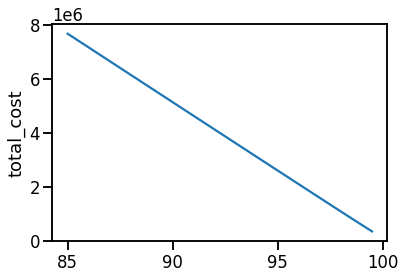

In [409]:
sns.lineplot(x=inventory_cost_levels.index,y=inventory_cost_levels['total_cost'])
plt.show()

In [344]:
type(ss_cost_list)

list

#### Calculate Safety Stock with optimal service level

In [332]:
# Desired service level
sl = .975
safety_stock = historical.groupby('forecast_key').apply(lambda x: safety_stock_func(x,sl))
safety_stock = pd.DataFrame(safety_stock,columns=['safety_stock']).round()
safety_stock['holding_cost'] = [item_holding_cost_dict.get(key) for key in safety_stock.index]
safety_stock_cost = sum(safety_stock['holding_cost']*safety_stock['safety_stock'])
safety_stock_cost

76588.821

In [ ]:

# Add safety stock to dataset
safety_stock.reset_index()
forecasts = forecasts.set_index("forecast_key").join(safety_stock)

print('\n SS Calcualted! \n Median SS: \n {}'.format(round(safety_stock['safety_stock'].median())) )

### Plot

Number of Obs: 62


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


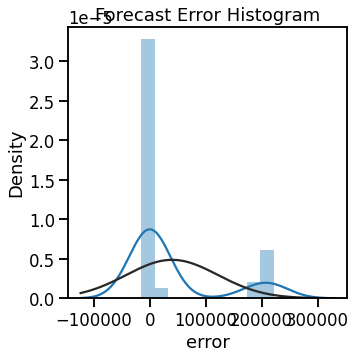

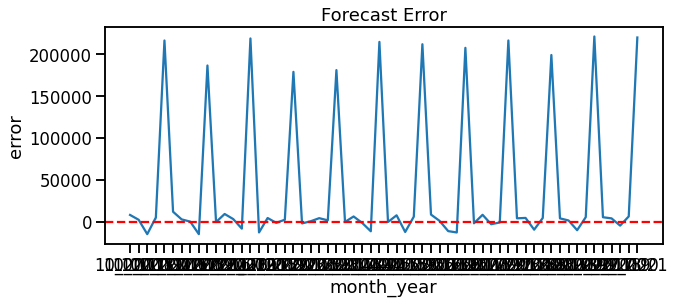

In [ ]:
from scipy.stats import norm

# Plot
sns.set_context('talk')
subset = historical[historical['forecast_key'].isin(historical['forecast_key'].drop_duplicates().sample())] 
subset = historical[historical['forecast_key'].isin(['64870'])] 
print('Number of Obs:',len(subset))

# Histogram
plt.figure(figsize=(5,5))
plt.title('Forecast Error Histogram')
sns.distplot(subset['error'],bins=10,fit=norm)
plt.show()

# Error plot
plt.figure(figsize=(10,4))
plt.title('Forecast Error')
sns.lineplot(y='error',x='month_year', data=subset)
plt.axhline(0, ls='--',color='red')
plt.show()

## Export to BigQuery

In [ ]:
from google.cloud import bigquery

# Save table locally
forecasts.to_csv('ss_forecasts.csv')

# Specify project and destination 
project_id = 'iowa-liquor-sales-266301'
bq_dataset_name = "forecasting"

# Local path of file to be uploaded
forecasts_path = "/content/ss_forecasts.csv"

file_paths = [forecasts_path]
table_names = ["ml_forecasts"]

# Construct a BigQuery client object
client = bigquery.Client(project = project_id)

# Batch load tables
for file_path,tb_name in zip(file_paths,table_names):
  
  table_id = "{}.{}.{}".format(project_id,bq_dataset_name,tb_name)

  job_config = bigquery.LoadJobConfig(
      source_format=bigquery.SourceFormat.CSV, 
      skip_leading_rows=1, 
      autodetect=True,
  )

  job_config.write_disposition = 'WRITE_TRUNCATE' # Replace data

  with open(file_path, "rb") as source_file:
      job = client.load_table_from_file(source_file, table_id,job_config=job_config)
      
  job.result()  # Waits for the job to complete.

  table = client.get_table(table_id)  # Make an API request.

  print(
      "Loaded {} rows and {} columns to {}".format(
          table.num_rows, len(table.schema), table_id
      )
  )

Loaded 232097 rows and 19 columns to iowa-liquor-sales-266301.forecasting.ml_forecasts
